In [1]:
#import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from minisom import MiniSom
import salishsea_tools.river_202108 as rivers
import xarray as xr
import cmocean.cm as cm

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0][0:20, :, :]

In [3]:
physics_202111 = xr.open_dataset('/ocean/cdonaldson/compare_daily_river/SalishSeaCast_day_avg_physics_20190101_20191231.nc')
# salinity = np.ma.masked_array(physics_202111.vosaline[0, :, :, :], mask=tmask[0:20, :, :])
salinity_unm = physics_202111.vosaline
tsteps = salinity_unm.shape[0]

In [4]:
tmask_exp = np.tile(np.expand_dims(tmask, axis=0), (tsteps, 1, 1, 1))
tmask_exp.shape

(365, 20, 898, 398)

In [8]:
# taking only the surface here; but we can do a depth-integration here later easily because ive applied
# the 3D mask to every element, for every day
salinity = np.ma.masked_array(salinity_unm, mask=tmask_exp)[:, 0, :, :]

In [10]:
salinity_mean = np.mean(salinity)
salinity_std = np.std(salinity)
salinity -= salinity_mean
salinity /= salinity_std

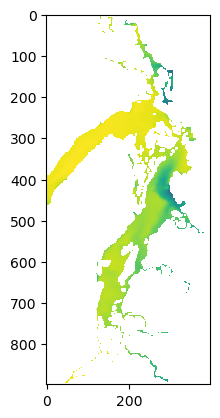

In [11]:
salinity_day = salinity[0, :, :]

plt.imshow(salinity_day)

In [12]:
%run som_class.ipynb

In [27]:
obs
# obs[np.isnan(obs)] = -9999

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [28]:
obs = np.array(salinity).reshape(salinity.shape[0], salinity.shape[1]*salinity.shape[2])
obs[np.isnan(obs)] = -9999

#define constants
Nx = 3
Ny = 3
N_nodes = Nx*Ny
N_obs = np.shape(obs)[0] #number of observations 
N_dims = np.shape(obs)[1] #number of dimensions per observation
learning_rate = 1e-2
N_epochs = 100
colours_list = 'pink_blue_red_purple'
colours_list = 'pinks'
colours_list = 'default2'

#initialize
som = SOM(Nx, Ny, obs, N_epochs, linewidth = 4, colours_list = colours_list)
som.initialize_map(node_shape = 'rect')

#train
som.train_map(learning_rate)
z = som.z #this is the pattern of each BMU
z_epochs = som.z_epochs #this is the pattern of each BMU through training (each epoch)
bmus = BMUs(som) #bmu of each observation
freq = BMU_frequency(som) #frequency of each bmu
dummy,bmus_colours = colourmap_2D(colours_list = colours_list, Nx = Nx, Ny = Ny) #colours of each bmu, for plotting
QE = som.QE() #quantization error of map
TE = som.TE() #topographic error of map


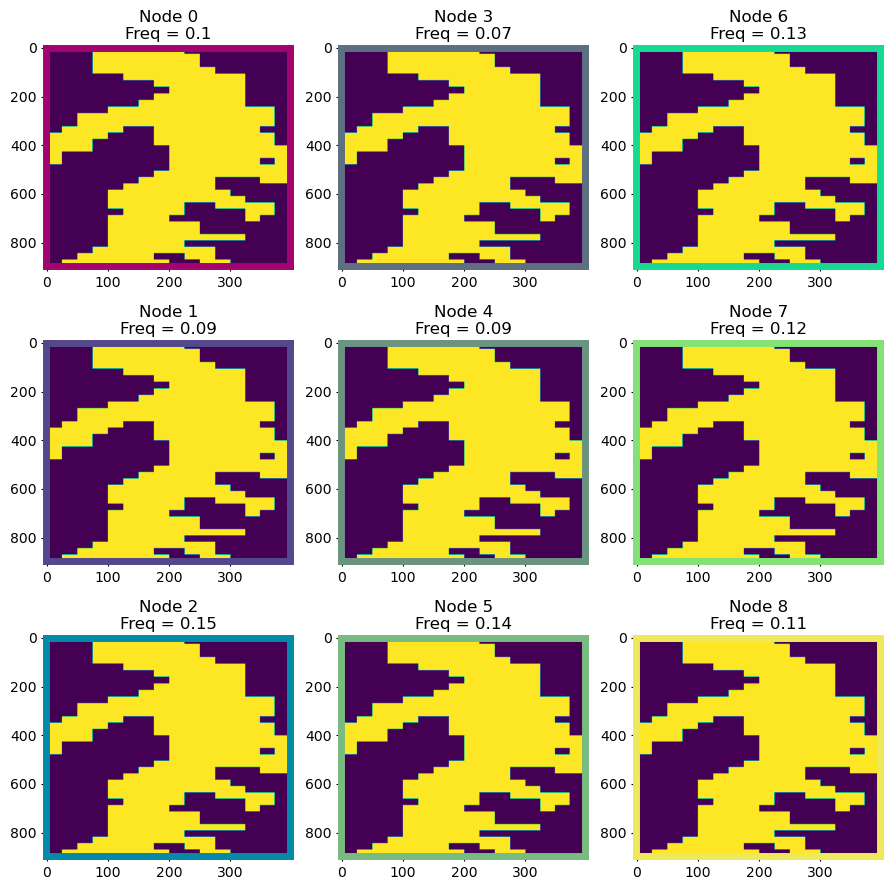

In [31]:
#visualize BMU patterns as images

indices = np.arange(N_nodes).reshape(Nx,Ny).T.flatten()
dummy,bmus_colours = colourmap_2D(colours_list = som.colours_list, Nx = Nx, Ny = Ny)

fig, axes = plt.subplots(nrows = Ny, ncols = Nx, figsize = (3*Nx, 3*Ny))

vmin = np.min(z)
vmax = np.max(z)

for kk, ax in enumerate(axes.flatten()): #for each axis (subplot)
    var = z[indices[kk],:].reshape(salinity.shape[1],salinity.shape[2])
    # ax.imshow(var, extent = P_extent, aspect = 'auto')
    # ax.plot(coastLon, coastLat,'k')
    # ax.set_xlim(P_extent[:2])
    # ax.set_ylim(P_extent[2:])
    ax.imshow(var, aspect = 'auto')
    ax.set_title('Node ' + str(indices[kk]) + '\nFreq = ' + str(np.round(BMU_frequency(som)[indices[kk]], decimals = 2)))
    
    #colour the borders
    for spine in ax.spines.values():
        spine.set_edgecolor(bmus_colours[indices[kk],:])
        spine.set_linewidth(5)
    
plt.tight_layout()